### This notebook demonstrates how to undersample and transform k-space data using ATOMMIC. Here we use the Calgary-Campinas 359 dataset.

#### Important! You need to have downloaded the CC359 dataset to properly run the notebook. For more information, please read [here](../projects/REC/CC359/README.md).


In [1]:
import h5py
import torch
import matplotlib.pyplot as plt
import numpy as np

from atommic.collections.common.data.subsample import create_masker
from atommic.collections.common.parts import fft, utils

# Specify path where CC359 data are downloaded

In [2]:
parent_data_path = input("Please enter the (downloaded) data path: ")

# Specify data paths specific to CC359

In [3]:
subject = 'e14110s3_P59904.7.h5'

In [4]:
data_path = f'{parent_data_path}/calgary-campinas_version-1.0/CC359/Raw-data/Multi-channel/12-channel/Val/{subject}'
mask_path = f'{parent_data_path}/calgary-campinas_version-1.0/CC359/poisson_sampling_h5/Val/{subject}'

# Read the data

In [5]:
# load the k-space
kspace = h5py.File(data_path)['kspace'][()]

In [6]:
kspace.shape

(256, 218, 170, 24)

In [7]:
# necessary operation for the CC359 dataset
kspace = np.moveaxis(kspace[..., ::2] + 1j * kspace[..., 1::2], -1, 1)

In [8]:
kspace.shape

(256, 12, 218, 170)

In [9]:
# load the masks
mask = h5py.File(mask_path)

In [10]:
mask.keys()

<KeysViewHDF5 ['mask_10x', 'mask_5x']>

In [11]:
# pick a mask
mask_5x = mask['mask_5x'][()]

In [12]:
mask_5x.shape

(256, 218, 170)

In [13]:
# pick a slice
slice_idx = 100
kspace = kspace[slice_idx]
mask_5x = mask_5x[slice_idx]

In [14]:
# transform to tensor
kspace = utils.to_tensor(kspace)
mask_5x = utils.to_tensor(mask_5x).unsqueeze(0).unsqueeze(-1)

In [15]:
masked_kspace = kspace * mask_5x

In [16]:
# initialize general parameters for transformations
fft_centered = False
fft_normalization = 'backward'
spatial_dims = (-2, -1)
coil_dim = 0

In [17]:
# apply the IFFT
imspace = fft.ifft2(kspace, fft_centered, fft_normalization, spatial_dims)
masked_imspace = fft.ifft2(masked_kspace, fft_centered, fft_normalization, spatial_dims)
# normalize the image for consistent visualization
imspace = imspace / torch.max(torch.abs(imspace))
masked_imspace = masked_imspace / torch.max(torch.abs(masked_imspace))
# compute the RSS target
rss_target = utils.rss_complex(imspace, coil_dim)
masked_rss_target = utils.rss_complex(masked_imspace, coil_dim)

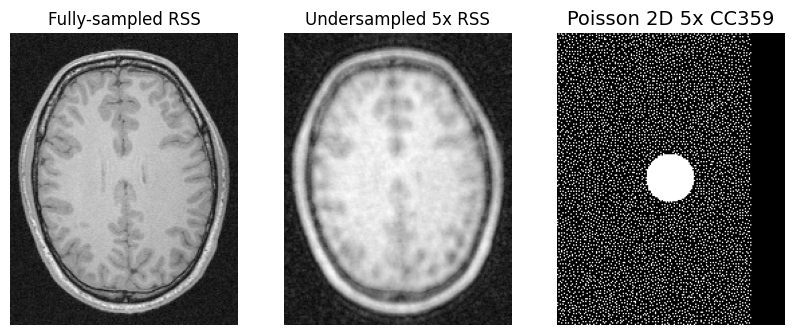

In [18]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(torch.abs(rss_target), cmap='gray')
plt.title('Fully-sampled RSS')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(torch.abs(masked_rss_target), cmap='gray')
plt.title('Undersampled 5x RSS')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(mask_5x.squeeze(), cmap='gray')
plt.title(f'Poisson 2D 5x CC359', fontsize=14)
plt.axis('off')
plt.show()

***
# ATOMMIC Undersampling
***

# Equispaced 1D

In [19]:
# initialize the undersampling masker
masker = create_masker('equispaced1d', 0.08, 4)
# apply the masker
masked_kspace, mask, acc = utils.apply_mask(kspace, masker)
# apply the IFFT
masked_imspace = fft.ifft2(masked_kspace, fft_centered, fft_normalization, spatial_dims)
# normalize the image for consistent visualization
masked_imspace = masked_imspace / torch.max(torch.abs(masked_imspace))
# compute the RSS target
masked_imspace_rss_target = utils.rss_complex(masked_imspace, coil_dim)

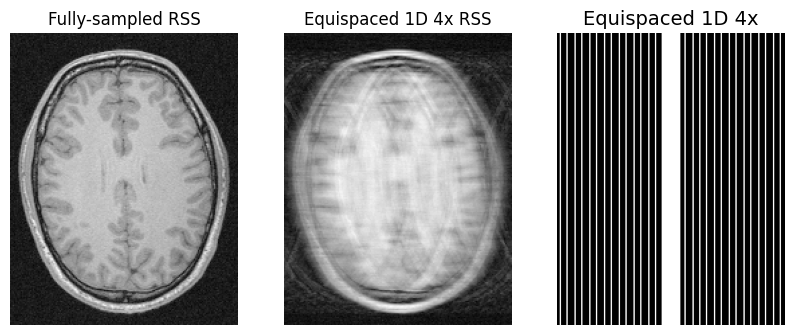

In [20]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(rss_target, cmap='gray')
plt.title('Fully-sampled RSS')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(masked_imspace_rss_target, cmap='gray')
plt.title(f'Equispaced 1D {acc:1.0f}x RSS')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(mask.repeat(1, masked_kspace.shape[1], 1, 1).squeeze(), cmap='gray')
plt.title(f'Equispaced 1D {acc:1.0f}x', fontsize=14)
plt.axis('off')
plt.show()

# Equispaced 2D

In [21]:
# initialize the undersampling masker
masker = create_masker('equispaced2d', 0.08, 4)
# apply the masker
masked_kspace, mask, acc = utils.apply_mask(kspace, masker)
# apply the IFFT
masked_imspace = fft.ifft2(masked_kspace, fft_centered, fft_normalization, spatial_dims)
# normalize the image for consistent visualization
masked_imspace = masked_imspace / torch.max(torch.abs(masked_imspace))
# compute the RSS target
masked_imspace_rss_target = utils.rss_complex(masked_imspace, coil_dim)

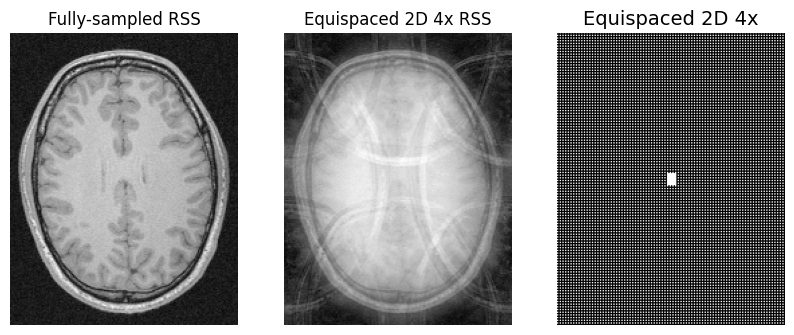

In [22]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(rss_target, cmap='gray')
plt.title('Fully-sampled RSS')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(masked_imspace_rss_target, cmap='gray')
plt.title(f'Equispaced 2D {acc:1.0f}x RSS')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(mask.squeeze(), cmap='gray')
plt.title(f'Equispaced 2D {acc:1.0f}x', fontsize=14)
plt.axis('off')
plt.show()

# Gaussian 1D

In [23]:
# initialize the undersampling masker
masker = create_masker('gaussian1d', 0.7, 4)
# apply the masker
masked_kspace, mask, acc = utils.apply_mask(kspace, masker, shift=True, center_scale=0.02)
# apply the IFFT
masked_imspace = fft.ifft2(masked_kspace, fft_centered, fft_normalization, spatial_dims)
# normalize the image for consistent visualization
masked_imspace = masked_imspace / torch.max(torch.abs(masked_imspace))
# compute the RSS target
masked_imspace_rss_target = utils.rss_complex(masked_imspace, coil_dim)

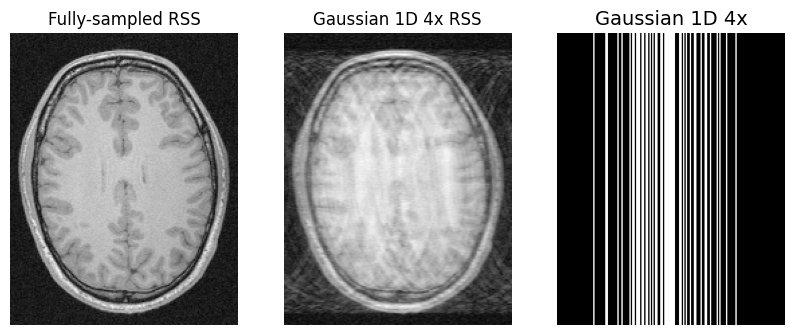

In [24]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(rss_target, cmap='gray')
plt.title('Fully-sampled RSS')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(masked_imspace_rss_target, cmap='gray')
plt.title(f'Gaussian 1D {acc:1.0f}x RSS')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(mask.repeat(1, masked_kspace.shape[1], 1, 1).squeeze(), cmap='gray')
plt.title(f'Gaussian 1D {acc:1.0f}x', fontsize=14)
plt.axis('off')
plt.show()

# Gaussian 2D

In [25]:
# initialize the undersampling masker
masker = create_masker('gaussian2d', 0.7, 4)
# apply the masker
masked_kspace, mask, acc = utils.apply_mask(kspace, masker, center_scale=0.02)
# apply the IFFT
masked_imspace = fft.ifft2(masked_kspace, fft_centered, fft_normalization, spatial_dims)
# normalize the image for consistent visualization
masked_imspace = masked_imspace / torch.max(torch.abs(masked_imspace))
# compute the RSS target
masked_imspace_rss_target = utils.rss_complex(masked_imspace, coil_dim)

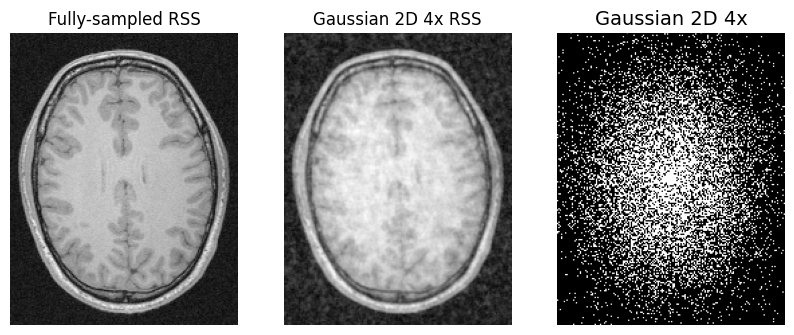

In [26]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(rss_target, cmap='gray')
plt.title('Fully-sampled RSS')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(masked_imspace_rss_target, cmap='gray')
plt.title(f'Gaussian 2D {acc:1.0f}x RSS')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(mask.squeeze(), cmap='gray')
plt.title(f'Gaussian 2D {acc:1.0f}x', fontsize=14)
plt.axis('off')
plt.show()

# Poisson 2D

In [27]:
# initialize the undersampling masker
masker = create_masker('poisson2d', 0.7, 4)
# apply the masker
masked_kspace, mask, acc = utils.apply_mask(kspace, masker)
# apply the IFFT
masked_imspace = fft.ifft2(masked_kspace, fft_centered, fft_normalization, spatial_dims)
# normalize the image for consistent visualization
masked_imspace = masked_imspace / torch.max(torch.abs(masked_imspace))
# compute the RSS target
masked_imspace_rss_target = utils.rss_complex(masked_imspace, coil_dim)

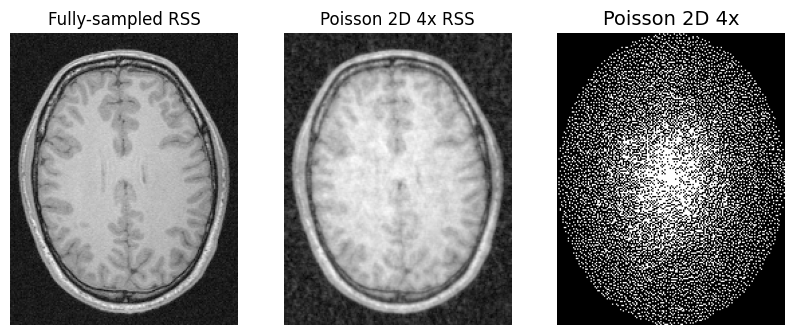

In [28]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(rss_target, cmap='gray')
plt.title('Fully-sampled RSS')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(masked_imspace_rss_target, cmap='gray')
plt.title(f'Poisson 2D {acc:1.0f}x RSS')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(mask.squeeze(), cmap='gray')
plt.title(f'Poisson 2D {acc:1.0f}x', fontsize=14)
plt.axis('off')
plt.show()

# Random 1D

In [29]:
# initialize the undersampling masker
masker = create_masker('random1d', 0.08, 4)
# apply the masker
masked_kspace, mask, acc = utils.apply_mask(kspace, masker)
# apply the IFFT
masked_imspace = fft.ifft2(masked_kspace, fft_centered, fft_normalization, spatial_dims)
# normalize the image for consistent visualization
masked_imspace = masked_imspace / torch.max(torch.abs(masked_imspace))
# compute the RSS target
masked_imspace_rss_target = utils.rss_complex(masked_imspace, coil_dim)

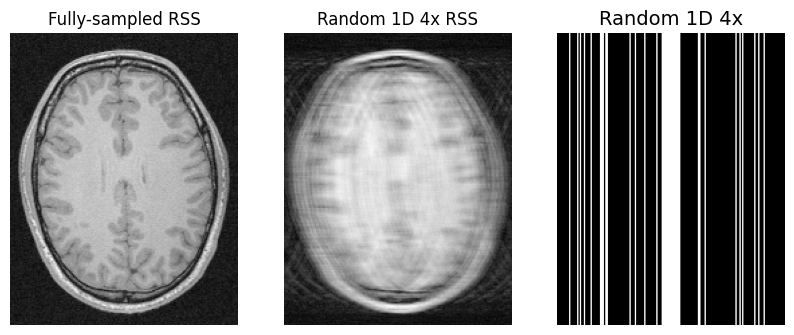

In [30]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(rss_target, cmap='gray')
plt.title('Fully-sampled RSS')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(masked_imspace_rss_target, cmap='gray')
plt.title(f'Random 1D {acc:1.0f}x RSS')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(mask.repeat(1, masked_kspace.shape[1], 1, 1).squeeze(), cmap='gray')
plt.title(f'Random 1D {acc:1.0f}x', fontsize=14)
plt.axis('off')
plt.show()

# Poisson 2D 20% Partial Fourier

In [31]:
# initialize the undersampling masker
masker = create_masker('poisson2d', 0.7, 4)
# apply the masker
masked_kspace, mask, _ = utils.apply_mask(kspace, masker)
masked_kspace_partial_fourier, mask_partial_fourier, acc = utils.apply_mask(kspace, masker, partial_fourier_percentage=0.2)
# apply the IFFT
masked_imspace = fft.ifft2(masked_kspace, fft_centered, fft_normalization, spatial_dims)
masked_imspace_partial_fourier = fft.ifft2(masked_kspace_partial_fourier, fft_centered, fft_normalization, spatial_dims)
# normalize the image for consistent visualization
masked_imspace = masked_imspace / torch.max(torch.abs(masked_imspace))
masked_imspace_partial_fourier = masked_imspace_partial_fourier / torch.max(torch.abs(masked_imspace_partial_fourier))
# compute the RSS target
masked_imspace_rss_target = utils.rss_complex(masked_imspace, coil_dim)
masked_imspace_partial_fourier_rss_target = utils.rss_complex(masked_imspace_partial_fourier, coil_dim)

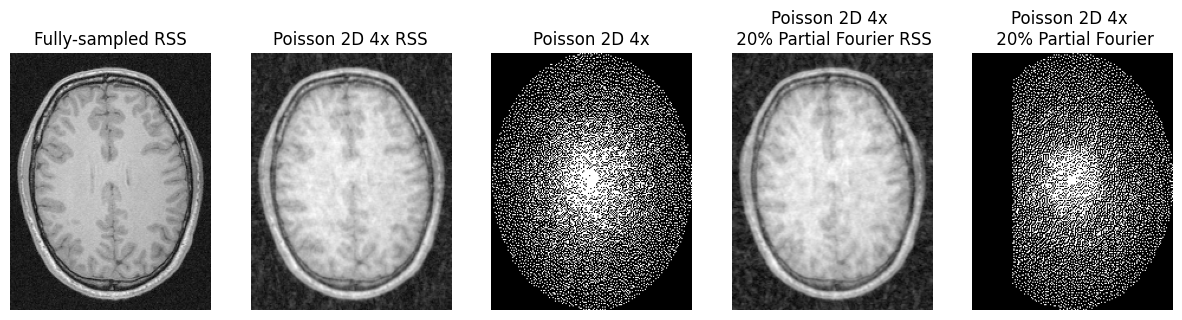

In [32]:
plt.figure(figsize=(15, 15))
plt.subplot(1, 5, 1)
plt.imshow(rss_target, cmap='gray')
plt.title('Fully-sampled RSS')
plt.axis('off')
plt.subplot(1, 5, 2)
plt.imshow(masked_imspace_rss_target, cmap='gray')
plt.title(f'Poisson 2D {acc:1.0f}x RSS')
plt.axis('off')
plt.subplot(1, 5, 3)
plt.imshow(mask.squeeze(), cmap='gray')
plt.title(f'Poisson 2D {acc:1.0f}x')
plt.axis('off')
plt.subplot(1, 5, 4)
plt.imshow(masked_imspace_partial_fourier_rss_target, cmap='gray')
plt.title(f'Poisson 2D {acc:1.0f}x \n 20% Partial Fourier RSS')
plt.axis('off')
plt.subplot(1, 5, 5)
plt.imshow(mask_partial_fourier.squeeze(), cmap='gray')
plt.title(f'Poisson 2D {acc:1.0f}x \n 20% Partial Fourier')
plt.axis('off')
plt.show()